In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import math
import decimal
%matplotlib inline

Cargo la base de datos completa de las mediciones de la M30.

In [ ]:
df = pd.read_csv('df_M30.csv', delimiter=';')

Cojo las mediciones de las espiras que se encuentren dentro de la M30.

In [ ]:
new_df = df[df['oldID'].str.contains('PM1.*1$')]

Filtro las mediciones con un identificador distinto del establecido por el convenio del documento descriptivo de la M30.

In [ ]:
new_df = new_df.loc[new_df['oldID'].str.len() == 7]

Establezco el kilómetro en el que se encuentra la espira a partir del identificador.

In [ ]:
new_df['KM'] = new_df["oldID"].str[3:5].astype(str) + "." + new_df["oldID"].str[5:6].astype(str)

Cojo las mediciones realizadas en un día específico.

In [ ]:
new_df = new_df[new_df['fecha'].str.contains('2015-08-04')]

Cambio el tipo de valor de ls kilómetros a decimal

In [ ]:
new_df[['KM']] = new_df.loc[:,['KM']].astype(np.float64)

Aplico el algoritmo de tráfico para obtener la densidad a partir de la densidad y de la velocidad media. Se asume que el escenario se encuentra en equilibrio para la aplicación de esta fórmula.

In [ ]:
new_df.loc[:, 'densidad'] = new_df.loc[:, "intensidad"] / new_df.loc[:, "vmed"]

In [ ]:
new_df.dropna(subset = ['densidad'])

A partir de la fecha proporcionada se crea una nueva columna con la hora de la medición realizada. Tras esto, se cambia el tipo del valor de string a decimal.

In [ ]:
new_df['Hora'] = new_df["fecha"].str[11:13].astype(str) + "." + new_df["fecha"].str[14:16].astype(str)
new_df[['Hora']] = new_df.loc[:,['Hora']].astype(np.float64)

Se ordenan las mediciones por la hora de la medición.

In [ ]:
new_df.sort_values('Hora').reset_index(drop=True)

Se exporta el dataframe de un día a una base de datos.

In [ ]:
new_df.to_csv('df_M30_KM_dia.csv', sep=';')

# Interpolación temporal

A continuación, se carga la base de datos de un día y se interpola temporalmente. Esto se realiza debido a que las mediciones están tomadas en intervalos de 15 minutos y se van a establecer mediciones cada minuto.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import math
import decimal
%matplotlib inline

In [ ]:
df = pd.read_csv('df_M30_KM_dia.csv', delimiter=',')

Una vez cargada la base de datos, se eliminan las mediciones corruptas, en este caso las mediciones del sensor ubicado en el kilómetro 0.2 y 0.9.

In [ ]:
df = df.sort_values(by=['KM', 'Hora'])
df = df.reset_index(drop=True)
df = df[['ID', 'oldID', 'fecha', 'intensidad', 'ocupacion', 'vmed', 'periodo_integracion',
                       'KM', 'densidad', 'Hora']]
df = df[~(df['KM'] == 0.2)]
df = df[~(df['KM'] == 0.9)]
df.index = range(len(df.index))

Una vez adaptada la base de datos, se interpola

In [ ]:
df_temp = pd.DataFrame([])
df_int = pd.DataFrame([])

for id in np.sort(df.oldID.value_counts().keys()):
    df_aux = df.loc[df['oldID'] == id]
    # Se crea la matriz de interpolación de tamaño: filas del id obtenido * 15 minutos interpolados
    #- 14 últimos minutos del día sin medición * 10 columnas
    nans = np.where(np.empty_like(np.arange((len(df_aux.index)*15-14)*10).reshape(len(df_aux.index)*15-14, 10)), np.nan, np.nan)
    df_new = pd.DataFrame(nans, columns=['ID','oldID','fecha','intensidad','ocupacion','vmed','periodo_integracion', 
                                         'KM', 'densidad', 'Hora'])
    # Se asignan los valores del dataframe
    j = 0
    for i in df_new.index.values.astype(int):
        # Si es un valor que está relleno, se copia entero
        if (i%15) == 0:
            if i != 0:
                j=j+1
            df_new.loc[i] = df_aux.values[j]
        else:
        # Si no es valor relleno, se copian sólo los valores iguales (ID, oldID, KM) y se asigna un periodo_int
            df_new.iloc[i, df.columns.get_loc('ID')] = df_aux.iloc[j, df.columns.get_loc('ID')]
            df_new.iloc[i, df.columns.get_loc('oldID')] = df_aux.iloc[j, df.columns.get_loc('oldID')]
            df_new.iloc[i, df.columns.get_loc('periodo_integracion')] = 1.0
            df_new.iloc[i, df.columns.get_loc('KM')] = df_aux.iloc[j, df.columns.get_loc('KM')]
    
    
    # se interpolan los valores de las mediciones.
    df_new['intensidad'] = df_new['intensidad'].interpolate()
    df_new['ocupacion'] = df_new['ocupacion'].interpolate()
    df_new['vmed'] = df_new['vmed'].interpolate()
    df_new['densidad'] = df_new['densidad'].interpolate()
    
    # Secrea un dataframe con la interpolación
    if id == 'PM10001':
        df_temp = df_new
    else:
        df_temp = df_temp.append(df_new, ignore_index=True)

Ahora es necesario interpolar la hora de la medición. Sin embargo, hay que tener cuidado, dado que la interpolación se realiza de manera decimal y estamos contemplando tiempo. Es por ello que hay que modificar los datos para no interpolar desde 59 hasta 99 minutos.

Primero se crea un dataframe con el oldID y la fecha.

In [ ]:
df_1 = pd.concat([df_temp['oldID'], df_temp['fecha']], axis=1, keys=['oldID', 'fecha'])

Se extraen los valores de 'Hora' y 'Minuto' y se cambia el formato de la fecha para adecuarlo al estándar de Pandas.

In [ ]:
df_1['fecha'] = pd.to_datetime(df_1['fecha'])
df_1['hour'] = df_1.fecha.dt.hour
df_1['minute'] = df_1.fecha.dt.minute
df_1['fecha'] = df_1.fecha.dt.strftime('%d-%m-%Y')

Ahora es necesario rellenar los valores existentes entre los datos recogidos. 

Para los minutos, es necesario establecer, manualmente, el valor anterior a la medición de la siguiente espira (que comienza en 0.0) al valor 59.0 para que no haya interpolaciones superiores a 59 minutos.

Para las horas, si el valor de la celda actual no está rellene, se rellena con el valor anterior.

Una vez hecho esto se pueden interpolar los minutos sin problemas. Tras esto, se crea una columna con el valor de las horas de las mediciones en decimal para poder representarlos y se copia a la columna de 'Hora' en el dataframe original.

In [ ]:
for i in df_1.index.values.astype(int):
    if i != 0 and df_1.iloc[i]['minute'] == 0.0 and df_1.iloc[i-1]['oldID'] == df_1.iloc[i]['oldID']:
        df_1.at[i-1,'minute'] =  59.0
    if i != 0 and pd.isnull(df_1.at[i,'hour']):
        df_1.at[i,'hour'] =  df_1.at[i-1,'hour']

        
df_1['minute'] = df_1['minute'].interpolate(method='linear')

df_1['time'] = ""
for i in df_1.index.values.astype(int):
    if df_1.iloc[i]['minute'] < 10.0:print("i:", i, "value: ", str(df_1.iloc[i, df_1.columns.get_loc('hour')].astype('int64')) + ".0" + str(df_1.iloc[i, df_1.columns.get_loc('minute')].astype('int64')))
        df_1.iloc[i, df_1.columns.get_loc('time')] = str(df_1.iloc[i, df_1.columns.get_loc('hour')].astype('int64')) + ".0" + str(df_1.iloc[i, df_1.columns.get_loc('minute')].astype('int64'))
    else:
        df_1.iloc[i, df_1.columns.get_loc('time')] = str(df_1.iloc[i, df_1.columns.get_loc('hour')].astype('int64')) + "." + str(df_1.iloc[i, df_1.columns.get_loc('minute')].astype('int64'))

df_temp['Hora'] = df_1['time']

Exporto a CSV el DataFrame

In [ ]:
df_temp.to_csv('df_M30_KM_dia_inter_temp.csv', sep=';')

# Interpolación espacial

Una vez realizada la interpolación temporal, es necesario conseguir medidas cada 100 metros de carretera para poder visualizar bien las transiciones entre las distintas velocidades medias obtenidas. 

Esto es útil dado que la M30 tiene mediciones en intervalos con una gran diferencia. De esta manera se consiguen datos equidistantes, tanto en tiempo como en distancia. Así, las gráficas obtenidas estarán completas y no tendran mediciones vacías.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import math
import decimal
%matplotlib inline

Cargo la base de datos interpolada temporalmente.

In [ ]:
df_good = pd.read_csv('df_M30_KM_dia_inter_temp.csv', delimiter=';')
df_good = df_good.drop(['Unnamed: 0'], axis=1)

Por cada filtrado temporal realizado (uno para cada minuto interpolado) se recogen las mediciones de las espiras (KM), se crea una matriz de interpolación, se asignan los valores comunes y se establece el valor kilómetrico interpolado. Une vez hecho esto se interpolan el resto de valores y se crea, progresivamente, el dataframe final. 

In [ ]:
df_esp = pd.DataFrame([])
df_int = pd.DataFrame([])

m30_km = 32.5
m30_centenas_m = int(m30_km*10)

for time in np.sort(df_good.Hora.value_counts().keys()):
    df_aux = df_good.loc[df_good['Hora'] == time]
    df_aux = df_aux.sort_values(by=['KM'])
    df_aux = df_aux.reset_index(drop=True)
    
    nans = np.where(np.empty_like(np.arange(m30_centenas_m*10).reshape(m30_centenas_m, 10)), np.nan, np.nan)
    df_new = pd.DataFrame(nans, columns=['ID','oldID','fecha','intensidad','ocupacion','vmed','periodo_integracion','KM','densidad','Hora'])
    
    #print(df_new.shape)
    
    df_new['ID'] = 'int_temp'
    df_new['oldID'] = 'int_temp'
    df_new['Hora'] = time
    df_new['fecha'] = df_aux.iloc[0, df_aux.columns.get_loc('fecha')]
    df_new['periodo_integracion'] = 1.0
    
    j=0
    k = 0
    for i in df_new.index.values.astype(int):
        if int(round(np.sort(df_aux.KM.value_counts().keys())[k]/0.1, 1)) == 322:
            k = 0
        if i == int(round(np.sort(df_aux.KM.value_counts().keys())[k]/0.1, 1)):
            df_new.loc[i] = df_aux.loc[j].values
            j += 1
            k += 1
        else:  
            df_new.at[i,'KM'] = i/10
            
    df_int = df_new.interpolate()
    if time == '0.0':
        df_esp = df_int
    else:
        df_esp = df_esp.append(df_int, ignore_index=True)

Se exporta el dataframe final a una base de datos

In [ ]:
df_esp.to_csv('df_M30_KM_dia_inter_temp_esp.csv', sep=';')

# Representación

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import math
import decimal
%matplotlib inline

Cargo las bases de datos.

In [2]:
# Cargo la base de datos proporcionada.
df = pd.read_csv('df_M30_KM_dia.csv', delimiter=',')

#Cargo la base de datos tras interpolar.
df_final = pd.read_csv('df_M30_KM_dia_inter_temp_esp.csv', delimiter=';')
df_final = df_final.drop(['Unnamed: 0'], axis=1)

Represento las mediciones existentes tras las interpolaciones. Como se puede apreciar ahora no hay zonas sin medición.

Text(0.5, 1.0, 'Gráfica de las mediciones tras interpolar la base de datos')

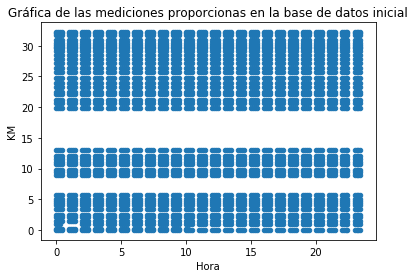

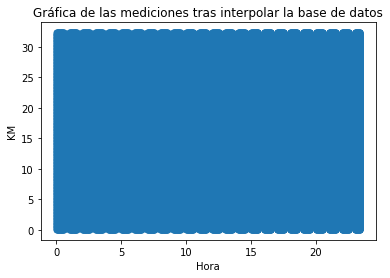

In [3]:
# Gráfica de las mediciones proporcionas en la base de datos inicial.
df.plot.scatter(x="Hora", y="KM")
plt.title("Gráfica de las mediciones proporcionas en la base de datos inicial")
# Gráfica de las mediciones tras interpolar la base de datos.
df_final.plot.scatter(x="Hora", y="KM")
plt.title("Gráfica de las mediciones tras interpolar la base de datos")

Represento el tráfico de las medicines obenidas

Text(0.5, 1.0, 'Medidicas interpoladas de la velocidad media')

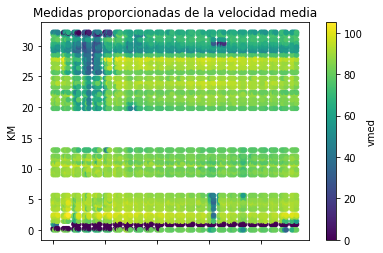

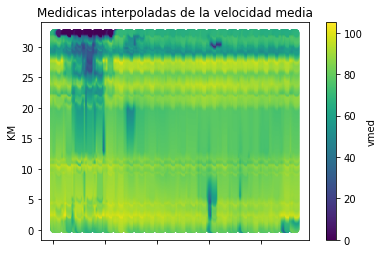

In [4]:
# Representación de la velocidad media medida proporcionadas en la base de datos e interpoladas
df.plot.scatter(x="Hora", y="KM", c="vmed", colormap='viridis')
plt.title("Medidas proporcionadas de la velocidad media")

df_final.plot.scatter(x="Hora", y="KM", c="vmed", colormap='viridis')
plt.title("Medidicas interpoladas de la velocidad media")